In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, train_test_split

from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from colorama import Fore, Back, Style
from sklearn.feature_selection import mutual_info_classif
!git clone https://github.com/analokmaus/kuma_utils.git
import sys; sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

fatal: destination path 'kuma_utils' already exists and is not an empty directory.


In [49]:
train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')
device = "cuda" 

<BarContainer object of 26 artists>

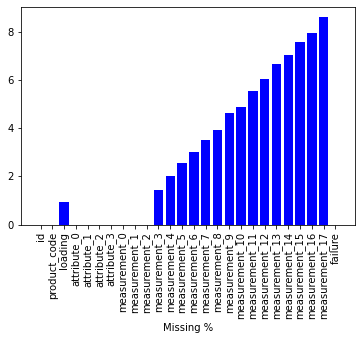

In [50]:
#show the missing value among different attribute
# nan=train.isna().sum()
percent = []
for column in train.columns:
    percent.append( train[column].isna().sum()/len(train)*100)

plt.xticks(rotation = 90)
plt.xlabel("Missing %")
plt.bar(train.columns, percent, color=['blue'])

In [ ]:
#see the correlation between features
figure(figsize=(15,15), dpi=90)
cor = train.corr()
sns.heatmap(cor, annot=True)
plt.show()

# Missing Values

In [51]:
train = pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv", index_col='id')
test = pd.read_csv("../input/tabular-playground-series-aug-2022/test.csv", index_col='id')
sub = pd.read_csv("../input/tabular-playground-series-aug-2022/sample_submission.csv")
train_data = train.drop('failure', axis=1).copy()
y = train.failure
test_data = test.copy()
numerical_cols = train_data.select_dtypes(np.number).columns.values.tolist()
categorical_cols = [x for x in train_data.columns.values if (x not in numerical_cols)]

In [52]:
def use_missing_values(column):
    new_column = column + '_missing'
    train_data[new_column] = train_data[column].isna() * 1
    test_data[new_column] = test_data[column].isna() * 1
for column in numerical_cols:
    use_missing_values(column)
train_data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8_missing,measurement_9_missing,measurement_10_missing,measurement_11_missing,measurement_12_missing,measurement_13_missing,measurement_14_missing,measurement_15_missing,measurement_16_missing,measurement_17_missing
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,0,0,0,0,0,0,1,0,0,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,0,0,0,0,0,0,0,0,0,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,0,0,0,1,0,0,0,0,0,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,0,0,0,0,0,0,0,0,0,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,0,0,0,0,0,0,0,0,0,0


In [53]:
#add missing vlaues 
imputer = LGBMImputer(n_iter=50)
# imputer = IterativeImputer(max_iter = 8, random_state = 0, skip_complete = True, n_nearest_features = 12)

imputer.fit(train_data[numerical_cols].append(test_data[numerical_cols]))
train_data[numerical_cols] = imputer.transform(train_data[numerical_cols])
test_data[numerical_cols] = imputer.transform(test_data[numerical_cols])

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

# Feature Engineering Ideas


In [56]:
group1_columns = []
group1_id = [3,4,9,10,11,12,13,14,15,16,17]
for i in group1_id:
    group1_columns += [f"measurement_{i:d}"]

group2_columns = []
group2_id = [5,6,7,8]
for i in group2_id:
    group2_columns += [f"measurement_{i:d}"]

train_data['attribute_2*3'] = train_data['attribute_2'] * train_data['attribute_3']
train_data['gr1_std'] = np.std(train_data[group1_columns], axis=1)
train_data['gr1_avg'] = np.mean(train_data[group2_columns], axis=1)

train_data['gr2_avg'] = np.mean(train_data[group2_columns], axis=1)
train_data['meas17/gr2_avg'] = train_data['measurement_17'] / train_data['gr2_avg']

test_data['attribute_2*3'] = test_data['attribute_2'] * test_data['attribute_3']
test_data['gr1_std'] = np.std(test_data[group1_columns], axis=1)
test_data['gr1_avg'] = np.mean(test_data[group2_columns], axis=1)

test_data['gr2_avg'] = np.mean(test_data[group2_columns], axis=1)
test_data['meas17/gr2_avg'] = test_data['measurement_17'] / test_data['gr2_avg']

numerical_cols = train_data.select_dtypes(np.number).columns.values.tolist()

# train_data.head()

# Label 

In [57]:
for column in categorical_cols:
    label_encoder = LabelEncoder()
    label_encoder.fit(train_data[column].append(test_data[column]))
    train_data[column] = label_encoder.transform(train_data[column])
    test_data[column] = label_encoder.transform(test_data[column])
train_data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_13_missing,measurement_14_missing,measurement_15_missing,measurement_16_missing,measurement_17_missing,attribute_2*3,gr1_std,gr1_avg,gr2_avg,meas17/gr2_avg
id,,,,,,,,,,,,,,,,,,,,,
0,0,80.10,1,3,9,5,7,8,4,18.040,...,0,1,0,0,0,45,215.415311,16.73350,16.73350,45.662892
1,0,84.89,1,3,9,5,14,3,3,18.213,...,0,0,0,0,0,45,191.779013,16.56175,16.56175,41.182665
2,0,82.43,1,3,9,5,12,1,5,18.057,...,0,0,0,0,0,45,186.182208,16.49600,16.49600,40.214355
3,0,101.07,1,3,9,5,13,2,6,17.295,...,0,0,0,0,0,45,233.245686,17.13950,17.13950,48.209224
4,0,188.06,1,3,9,5,9,2,8,19.346,...,0,0,0,0,0,45,162.402011,15.53375,15.53375,37.330651


In [58]:
X = train_data.copy()
y = train.failure.copy()
test_X = test_data.copy()

scores = mutual_info_classif(X, y, random_state=1)
scores = pd.Series(scores, name="MI Scores")
scores = scores[scores > 1e-3]
scores = scores.sort_values(ascending=True)
columns = train_data.columns[scores.index]

In [59]:
columns = columns.tolist()
columns.remove('product_code')
print(columns)

train = train_data[columns]
test  = test_data[columns]

['measurement_7_missing', 'measurement_8_missing', 'measurement_16_missing', 'attribute_2', 'measurement_13_missing', 'measurement_11', 'attribute_0', 'measurement_7', 'gr1_std', 'measurement_5_missing', 'attribute_3', 'measurement_4_missing', 'measurement_8', 'gr1_avg', 'measurement_12', 'gr2_avg', 'measurement_1', 'loading']


### 4. Models
### 4.1 LogisticRegression

In [60]:
lr_pred = np.zeros(len(test))
importance_list = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train, y)):
    x_train, x_val = train.iloc[train_idx], train.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = test.copy()
    
    model = LogisticRegression(max_iter=1000, C=0.0001, penalty='l2', solver='newton-cg') # , class_weight='balanced'
    model.fit(x_train, y_train)
    importance_list.append(model.coef_.ravel())

    lr_pred += model.predict_proba(test)[:, 1] / 5


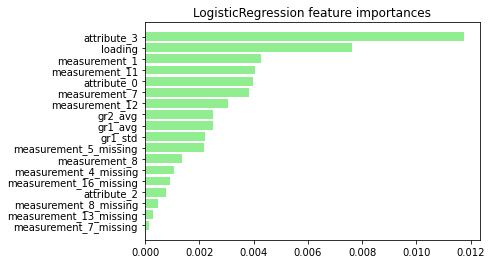

In [61]:
importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train.columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train.columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

### 5. Submissions


In [62]:
sub['failure'] = lr_pred
sub[['id', 'failure']].to_csv('submissions.csv', index=False)
sub

,id,failure
0,26570,0.197894
1,26571,0.181140
2,26572,0.188012
3,26573,0.183984
4,26574,0.344065
...,...,...
20770,47340,0.236912
20771,47341,0.147945
20772,47342,0.150977
20773,47343,0.209783
